In [3]:
import pandas as pd
import pyarrow.parquet as pq

#read in the data
trips = pq.read_table('yellow_tripdata_2021-06.parquet')
trips = trips.to_pandas()

In [12]:
#check reading in the data
print(trips.head())
print(trips.shape[0])
print(trips.columns)

   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2021-06-01 00:13:26   2021-06-01 00:17:14              1.0   
1         1  2021-06-01 00:32:23   2021-06-01 01:07:04              1.0   
2         1  2021-06-01 00:12:15   2021-06-01 00:15:28              0.0   
3         1  2021-06-01 00:35:00   2021-06-01 00:53:17              0.0   
4         2  2021-06-01 00:31:01   2021-06-01 00:52:27              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           0.90         1.0                  N           186            50   
1          23.00         1.0                  N           132            18   
2           0.90         1.0                  N           138            70   
3          11.20         1.0                  N           138           189   
4           9.49         1.0                  N           138           142   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \


In [16]:
#DATA CLEANING

#Remove negative tip_amount and negative total_amount
trips = trips[(trips['tip_amount'] >= 0) & (trips['total_amount'] >= 0)]
print(trips.shape[0]) #2821794
#Remove trip_distance with zero 
trips = trips[(trips['trip_distance']) > 0]
print(trips.shape[0])
#Remove passenger_count with zero or NaN and super high passenger (passenger less than or equal to 6)
trips = trips[(trips['passenger_count'] > 0) & (trips['passenger_count'] <= 6) & trips['passenger_count'].notnull()]
print(trips.shape[0])
#Clean up borough
boroughs = pd.read_csv('taxi_zone_lookup.csv')
mapping_dict = dict(zip(boroughs['LocationID'], boroughs['Borough']))
trips['pickup_borough'] = trips['PULocationID'].map(mapping_dict)
trips['dropoff_borough'] = trips['DOLocationID'].map(mapping_dict)

2604088
2604088
2604088
0          Manhattan
1              Bronx
4          Manhattan
5          Manhattan
6          Manhattan
             ...    
2710721    Manhattan
2710722    Manhattan
2710723    Manhattan
2710724    Manhattan
2710725    Manhattan
Name: dropoff_borough, Length: 2604088, dtype: object


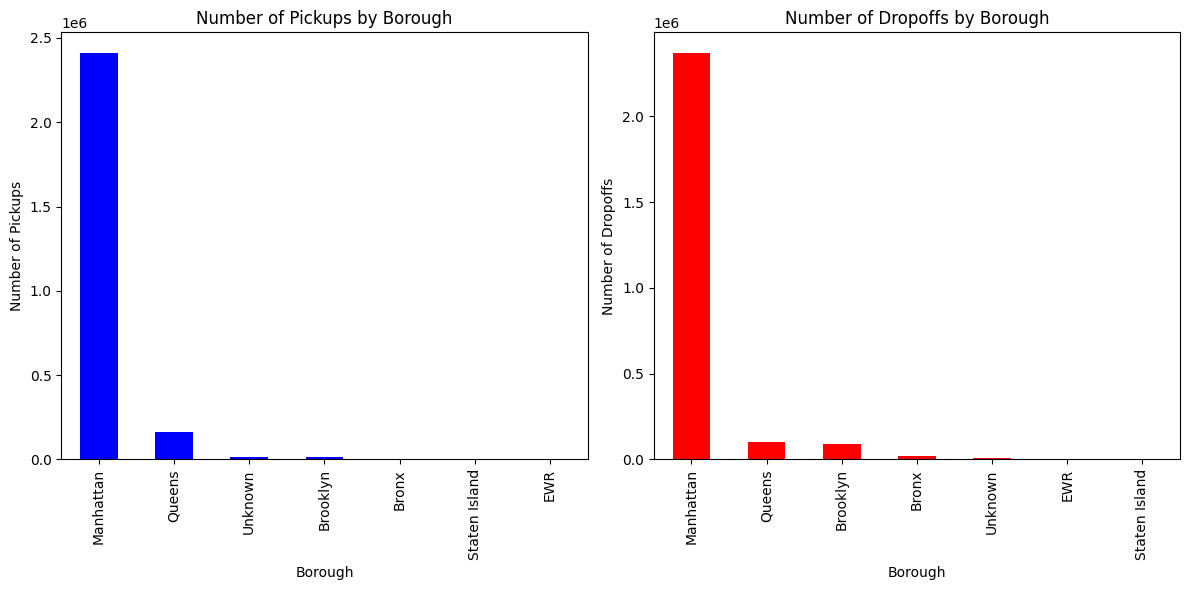

In [21]:
#EXPLORATORY ANALYSIS
import matplotlib.pyplot as plt

pickup_counts = trips['pickup_borough'].value_counts()
dropoff_counts = trips['dropoff_borough'].value_counts()
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
pickup_counts.plot(kind='bar', color='blue')
plt.title('Number of Pickups by Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Pickups')
plt.subplot(1, 2, 2)
dropoff_counts.plot(kind='bar', color='red')
plt.title('Number of Dropoffs by Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Dropoffs')
plt.tight_layout()
plt.show()

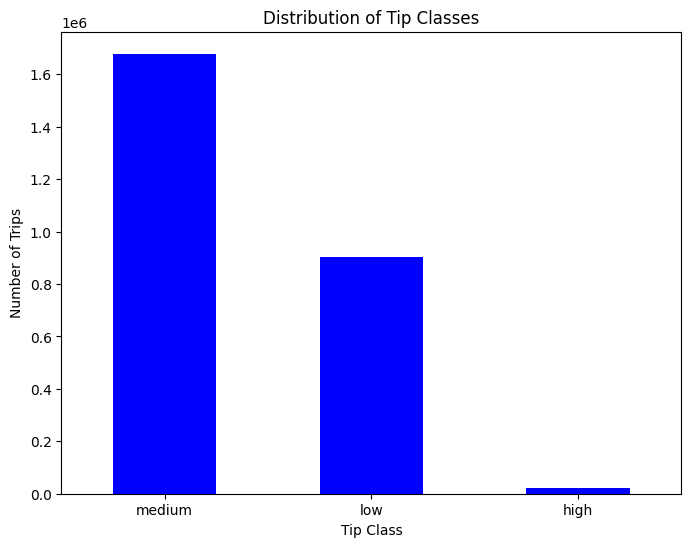

In [22]:
#TRIP PERCENTAGE
#idea to create a categorical variable with 3 classes: low tip, medium tip, and high tip amount and we can predict this
trips['tip_percentage'] = (trips['tip_amount'] / trips['total_amount']) * 100
def classify_tip_percentage(tip_percentage):
    if tip_percentage < 10:
        return 'low'
    elif 10 <= tip_percentage < 25:
        return 'medium'
    else:
        return 'high'
trips['tip_class'] = trips['tip_percentage'].apply(classify_tip_percentage)
tip_class_counts = trips['tip_class'].value_counts()
plt.figure(figsize=(8, 6))
tip_class_counts.plot(kind='bar', color='blue')
plt.title('Distribution of Tip Classes')
plt.xlabel('Tip Class')
plt.ylabel('Number of Trips')
plt.xticks(rotation=0)
plt.show()